In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from yellowbrick.contrib.classifier import DecisionViz
from sklearn.decomposition import PCA
from itertools import product
from imblearn.datasets import make_imbalance
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from yellowbrick.datasets import load_credit
from yellowbrick.features import PCA as yPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score 
from scikitplot.metrics import plot_precision_recall, plot_roc, plot_cumulative_gain, plot_lift_curve
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, classification_report

In [2]:
# Dataset con attributi originali
df = pd.read_csv("dataset_All_normalized.csv")
class_name = 'Occupancy'

In [3]:
df.head()

,Temperature,Light,CO2,HumidityRatio,Day,Afternoon,Evening,Night,Weekday,Weekend,Occupancy
0,0.869029,0.603964,0.208231,0.549737,0,1,0,0,1,0,1
1,0.872357,0.596946,0.215163,0.551972,0,1,0,0,1,0,1
2,0.874576,0.591029,0.220898,0.549997,0,1,0,0,1,0,1
3,0.873190,0.509582,0.224045,0.544374,0,1,0,0,1,0,1
4,0.879014,0.504267,0.226675,0.550376,0,1,0,0,1,0,1


In [4]:
# Funzione che viene chiamata sul:
# - y_true: target reale
# - y_pred: target predetto dal classificatore
# stampa: matrice di confusione, accuracy, precision, recall, specificity, F1
def result_pred(y_true, y_pred):
    print("**** Matrice di Confusione *****")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(' True negative: %d False negative: %d' % (tn, fn))
    print(' True positive: %d False positive: %d' % (tp, fp))
    print("____________________________________________")

    # Calcolo dell'accuracy
    print("***** Calcolo dell'accuracy *****")
    accuracy = accuracy_score(y_true, y_pred)    
    print('Frazione di campioni correttamente correlati: %0.4f' % accuracy)
    accuracy = accuracy_score(y_true, y_pred, False)
    print("Numero di campioni correttamente correlati: ", accuracy)    
    print("____________________________________________")

    # Calcolo della precision
    print("**** Calcolo della precisione *****")
    #Percentuale di classificazioni positive che sono corrette
    #se dico "positivo" dico giusto?
    precision = precision_score(y_true, y_pred)
    print('Percentuale di classificazioni positive che sono corrette: %0.4f' % precision)   
    print("____________________________________________")    

    # Calcolo della recall
    print("**** Calcolo della recall (sensitivity) *****")
    recall = recall_score(y_true, y_pred)
    print('Percentuale di elementi positivi del testing set che sono stati classificati come positivi: %0.4f' % recall)
    print("____________________________________________")    

    # Calcolo della specificity
    print("**** Calcolo della specificity *****")
    specificity = tn / (tn+fp)
    print('Percentuale di elementi negativi del testing set che sono stati classificati come negativi: %0.4f' % specificity)
    print("____________________________________________")   
    
    # Calcolo dell'F1 score
    print("**** Calcolo della F1 score *****")
    f1 = f1_score(y_true, y_pred)
    #Il punteggio F1 può essere interpretato come una media ponderata della precisione e della recall, 
    #in cui un punteggio F1 raggiunge il suo valore migliore a 1 e il punteggio peggiore a 0.
    print('F1 scores: %0.4f' % f1)
    print("____________________________________________")   
    
    # Stampiamo le stesse statistiche dalla funzione report
    print(classification_report(y_test, y_pred))
    
    print("Con le tecniche viste finora non viene fornita nessuna informazione sulla “gravità” degli errori (“errore lieve” oppure “errore grave)")
    print("per questo si usano la curva CMC, la curva ROC")

In [5]:
def plot_res(y_pred, y_score, y_test):
    #ROC CURVE: implementazione legata esclusivamente all'attività di classificazione binaria
    #false positive rate, true positive rate
    print("****** ROC CURVE + AUC?: passo passo *******")
    fprate, tprate, threashold = roc_curve(y_test, y_score[:, 1])
    auc_score = auc(fprate, tprate)
    plt.plot(fprate, tprate, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (auc_score))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve', fontsize=16)
    plt.legend(loc="lower right", fontsize=14, frameon=False)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.show()

    print("____________________________________")
    print("****** VALORE DI AUC *******")    
    print(roc_auc_score(y_test, y_score[:,1]))    
    
    print("____________________________________")
    print("****** ROC CURVE: con metodo diretto *******")
    plot_roc(y_test, y_score)
    plt.show()
    
    print("____________________________________")
    print("****** Precision recall: con metodo diretto *******")
    plot_precision_recall(y_test, y_score)
    plt.show()
    

    print("____________________________________")
    print("****** Cumulative gain: con metodo diretto *******")
    plot_cumulative_gain(y_test, y_score)
    plt.show()
    
    
    print("____________________________________")
    print("****** Lift curve: con metodo diretto *******")    
    plot_lift_curve(y_test, y_score)
    plt.show()

In [6]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000, stratify=y)

# Linear SVC

In [7]:
from sklearn.svm import LinearSVC

In [11]:
from sklearn.model_selection import GridSearchCV
y = df['Occupancy']
X = df.drop(columns=['Occupancy'])

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000)

# Set the parameters by cross-validation
tuned_parameters = {
    'tol':(1.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6),
    'C': (0.001, 0.05, 0.01, 0.1, 1.0, 10.0, 50, 100.0)
}
# Set the parameters by cross-validation
k_fold = StratifiedKFold(n_splits=4, random_state=42)

scores = ['f1', 'accuracy']

for score in scores:
    print("# Tuning hyper-parameters for ----> %s" % score)
    print()
    
    svm = LinearSVC()
    
    clf = GridSearchCV(svm, tuned_parameters, error_score='raise', cv=k_fold, scoring=score)
                     
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    print("**** Matrice di Confusione *****")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(' True negative: %d False negative: %d' % (tn, fn))
    print(' True positive: %d False positive: %d' % (tp, fp))
    print("____________________________________________")

c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


# Tuning hyper-parameters for ----> f1



c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-p

c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-p

Best parameters set found on development set:

{'C': 1.0, 'tol': 1.0}

Grid scores on development set:

0.936 (+/-0.004) for {'C': 0.001, 'tol': 1.0}
0.938 (+/-0.006) for {'C': 0.001, 'tol': 0.1}
0.938 (+/-0.006) for {'C': 0.001, 'tol': 0.01}
0.938 (+/-0.006) for {'C': 0.001, 'tol': 0.001}
0.938 (+/-0.006) for {'C': 0.001, 'tol': 0.0001}
0.938 (+/-0.006) for {'C': 0.001, 'tol': 1e-05}
0.938 (+/-0.006) for {'C': 0.001, 'tol': 1e-06}
0.980 (+/-0.004) for {'C': 0.05, 'tol': 1.0}
0.980 (+/-0.004) for {'C': 0.05, 'tol': 0.1}
0.980 (+/-0.004) for {'C': 0.05, 'tol': 0.01}
0.980 (+/-0.004) for {'C': 0.05, 'tol': 0.001}
0.980 (+/-0.004) for {'C': 0.05, 'tol': 0.0001}
0.980 (+/-0.004) for {'C': 0.05, 'tol': 1e-05}
0.980 (+/-0.004) for {'C': 0.05, 'tol': 1e-06}
0.978 (+/-0.005) for {'C': 0.01, 'tol': 1.0}
0.978 (+/-0.005) for {'C': 0.01, 'tol': 0.1}
0.978 (+/-0.005) for {'C': 0.01, 'tol': 0.01}
0.978 (+/-0.005) for {'C': 0.01, 'tol': 0.001}
0.978 (+/-0.005) for {'C': 0.01, 'tol': 0.0001}
0.978 (+

c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-p

c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-p

Best parameters set found on development set:

{'C': 100.0, 'tol': 0.001}

Grid scores on development set:

0.969 (+/-0.003) for {'C': 0.001, 'tol': 1.0}
0.970 (+/-0.003) for {'C': 0.001, 'tol': 0.1}
0.970 (+/-0.003) for {'C': 0.001, 'tol': 0.01}
0.970 (+/-0.003) for {'C': 0.001, 'tol': 0.001}
0.970 (+/-0.003) for {'C': 0.001, 'tol': 0.0001}
0.970 (+/-0.003) for {'C': 0.001, 'tol': 1e-05}
0.970 (+/-0.003) for {'C': 0.001, 'tol': 1e-06}
0.990 (+/-0.002) for {'C': 0.05, 'tol': 1.0}
0.990 (+/-0.002) for {'C': 0.05, 'tol': 0.1}
0.990 (+/-0.002) for {'C': 0.05, 'tol': 0.01}
0.990 (+/-0.002) for {'C': 0.05, 'tol': 0.001}
0.990 (+/-0.002) for {'C': 0.05, 'tol': 0.0001}
0.990 (+/-0.002) for {'C': 0.05, 'tol': 1e-05}
0.990 (+/-0.002) for {'C': 0.05, 'tol': 1e-06}
0.990 (+/-0.002) for {'C': 0.01, 'tol': 1.0}
0.990 (+/-0.002) for {'C': 0.01, 'tol': 0.1}
0.990 (+/-0.002) for {'C': 0.01, 'tol': 0.01}
0.990 (+/-0.002) for {'C': 0.01, 'tol': 0.001}
0.990 (+/-0.002) for {'C': 0.01, 'tol': 0.0001}
0.99

c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


**** Matrice di Confusione *****
 True negative: 4683 False negative: 1
 True positive: 1424 False positive: 60
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.9901
Numero di campioni correttamente correlati:  6107
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.9596
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 0.9993
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.9873
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.9790
____________________________________________
              precision    recall  f1-score   

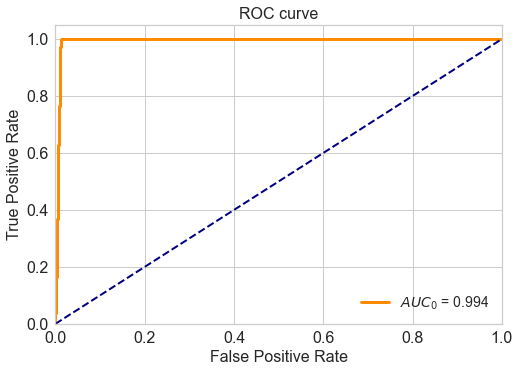

____________________________________
****** VALORE DI AUC *******
0.9941104712022518
____________________________________
****** ROC CURVE: con metodo diretto *******


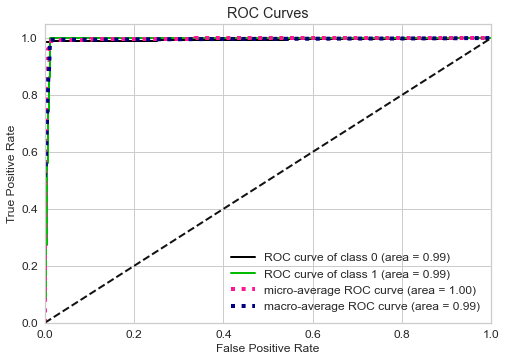

____________________________________
****** Precision recall: con metodo diretto *******


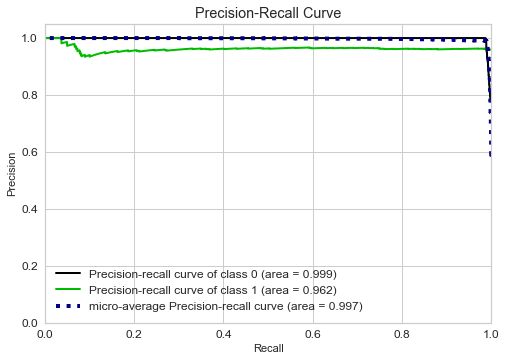

____________________________________
****** Cumulative gain: con metodo diretto *******


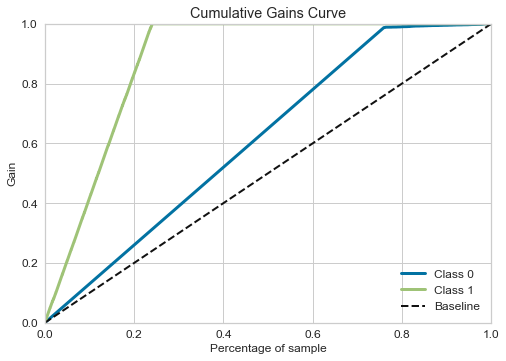

____________________________________
****** Lift curve: con metodo diretto *******


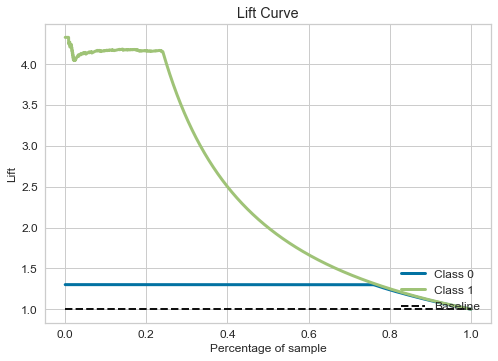

In [15]:
from sklearn.calibration import CalibratedClassifierCV
y = df['Occupancy']
X = df.drop(columns=['Occupancy'])
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000, stratify=y)

clf = LinearSVC(C=1.0, tol = 1.0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
result_pred(y_test, y_pred)
cclf = CalibratedClassifierCV(base_estimator=clf, cv=5)
cclf.fit(X_train, y_train)
y_pred = cclf.predict(X_test)
y_score = cclf.predict_proba(X_test)
plot_res(y_pred, y_score, y_test)

### Otteniamo lo stesso valore di F1 score con solo:
### "Temperature", "Light", "CO2", "HumidityRatio", "Evening", "Weekday"

In [38]:
from sklearn.calibration import CalibratedClassifierCV
y = df['Occupancy']
X = df[["Temperature", "Light", "CO2", "HumidityRatio", "Evening", "Weekday"]]
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000, stratify=y)

clf = LinearSVC(C=1.0, tol = 1.0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
result_pred(y_test, y_pred)

**** Matrice di Confusione *****
 True negative: 4683 False negative: 2
 True positive: 1423 False positive: 60
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.9899
Numero di campioni correttamente correlati:  6106
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.9595
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 0.9986
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.9873
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.9787
____________________________________________
              precision    recall  f1-score   

c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


# Prova con solo 2 Features - Plot Support Vector

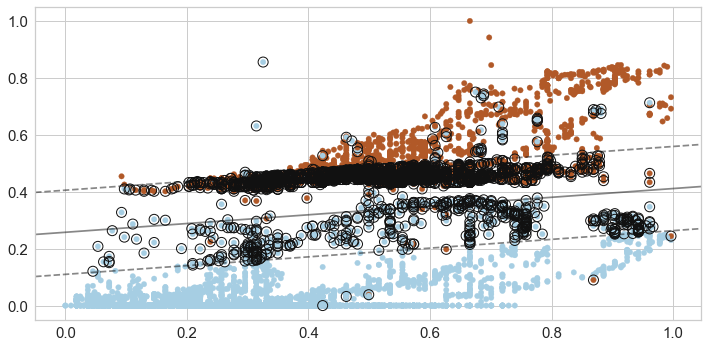

**** Matrice di Confusione *****
 True negative: 4660 False negative: 3
 True positive: 1422 False positive: 83
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.9861
Numero di campioni correttamente correlati:  6082
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.9449
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 0.9979
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.9825
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.9706
____________________________________________
              precision    recall  f1-score   

In [70]:

from sklearn.svm import LinearSVC
BIGGER_SIZE = 11
X = df[["Temperature", "Light"]].values
#X = X[0:1000]
y = df[class_name]
#y = y[0:1000]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000, stratify=y)

def plt_2f(X, y, X_test, y_test):
    plt.figure(figsize=(10, 5))
    # "hinge" is the standard SVM loss
    clf = LinearSVC(C=1.0, tol = 1.0).fit(X, y)
    # obtain the support vectors through the decision function
    decision_function = clf.decision_function(X)
    # we can also calculate the decision function manually
    # decision_function = np.dot(X, clf.coef_[0]) + clf.intercept_[0]
    support_vector_indices = np.where((2 * y - 1) * decision_function <= 1)[0]
    support_vectors = X[support_vector_indices]

    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
    plt.tight_layout()
    plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels   
    plt.show()
    clf.fit(X, y)
    y_pred = clf.predict(X_test)
    result_pred(y_test, y_pred)
plt_2f(X_train, y_train, X_test, y_test)

# Non Linear SVM

In [72]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
# READ AND DROP COLUMNS
y = df['Occupancy']
X = df.drop(columns=['Occupancy'])

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000, stratify=y)

# Set the parameters by cross-validation
tuned_parameters = {
    'kernel' : ('linear', 'rbf', 'poly', 'sigmoid'),
    'C':(0.001, 0.01, 0.1, 1.0, 10.0, 100.0),
    'gamma': (1.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6),
}
# Set the parameters by cross-validation
k_fold = StratifiedKFold(n_splits=4, random_state=42)

#scores = ['recall', 'f1', 'accuracy' , 'precision']
scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for ----> %s" % score)
    print()
    
    svm = SVC()
    
    clf = GridSearchCV(svm, tuned_parameters, error_score='raise', cv=k_fold, scoring=score)
                         
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    print("**** Matrice di Confusione *****")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(' True negative: %d False negative: %d' % (tn, fn))
    print(' True positive: %d False positive: %d' % (tp, fp))
    print("____________________________________________")

c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


# Tuning hyper-parameters for ----> f1

Best parameters set found on development set:

{'C': 1.0, 'gamma': 1.0, 'kernel': 'poly'}

Grid scores on development set:

0.843 (+/-0.054) for {'C': 0.001, 'gamma': 1.0, 'kernel': 'linear'}
0.709 (+/-0.020) for {'C': 0.001, 'gamma': 1.0, 'kernel': 'rbf'}
0.960 (+/-0.010) for {'C': 0.001, 'gamma': 1.0, 'kernel': 'poly'}
0.000 (+/-0.000) for {'C': 0.001, 'gamma': 1.0, 'kernel': 'sigmoid'}
0.843 (+/-0.054) for {'C': 0.001, 'gamma': 0.1, 'kernel': 'linear'}
0.000 (+/-0.000) for {'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}
0.000 (+/-0.000) for {'C': 0.001, 'gamma': 0.1, 'kernel': 'poly'}
0.000 (+/-0.000) for {'C': 0.001, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.843 (+/-0.054) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'linear'}
0.000 (+/-0.000) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}
0.000 (+/-0.000) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'poly'}
0.000 (+/-0.000) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.843 (+/-0.054) for {'C': 0

**** Matrice di Confusione *****
 True negative: 4682 False negative: 0
 True positive: 1425 False positive: 61
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.9901
Numero di campioni correttamente correlati:  6107
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.9590
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 1.0000
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.9871
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.9790
____________________________________________
              precision    recall  f1-score   

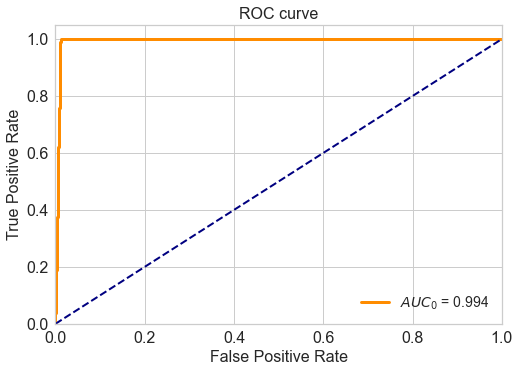

____________________________________
****** VALORE DI AUC *******
0.9942035354039748
____________________________________
****** ROC CURVE: con metodo diretto *******


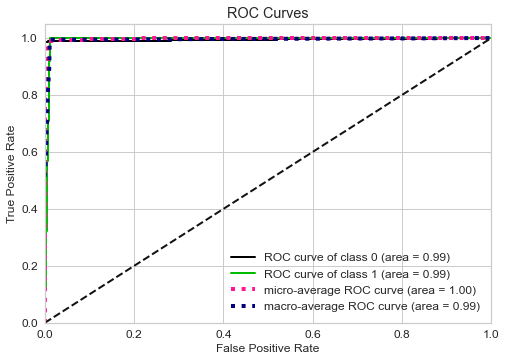

____________________________________
****** Precision recall: con metodo diretto *******


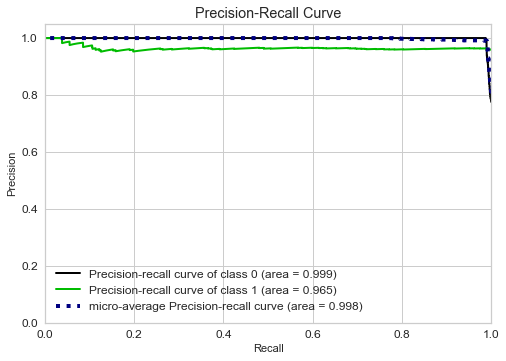

____________________________________
****** Cumulative gain: con metodo diretto *******


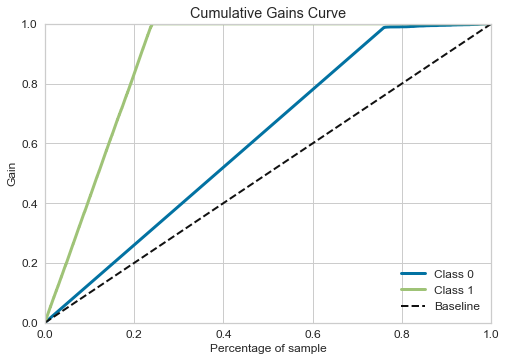

____________________________________
****** Lift curve: con metodo diretto *******


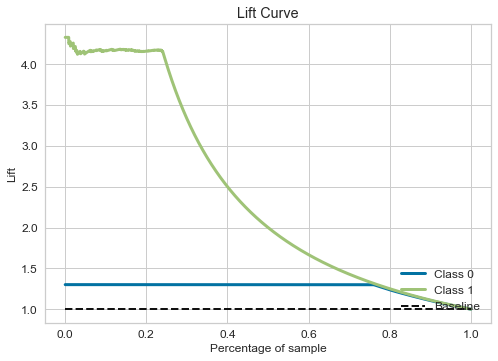

In [73]:
clf = SVC(gamma=1.0, C=1.0, kernel='poly', probability= True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
result_pred(y_test, y_pred)
y_score = clf.predict_proba(X_test)
plot_res(y_pred, y_score, y_test)

In [97]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
import matplotlib.pyplot as plt
import random


y = df['Occupancy']
X = df.drop(columns=['Occupancy'])

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000, stratify=y)

param_C =  [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 1.0001, 1.0005, 1.001, 1.005, 1.01, 
            1.05, 1.1, 1.5, 2.0]
param_gamma= [1.0,0.1, 0.01, 0.001, 0.0001]

accuracy =[]
for i in param_C:
    tmp = []
    for j in param_gamma:
        print("C = " + str(i) + " Gamma = " + str(j))
        svm = SVC(C=i, gamma=j)
        svm.fit(X_train, y_train)
        y_true, y_pred = y_test, svm.predict(X_test)
        acc = accuracy_score(y_true, y_pred)
        error_rate = 1 - acc
        print("Error rate = " + str(error_rate))
        tmp.append(error_rate)   
    accuracy.append(tmp)

C = 0.0001 Gamma = 1.0
Error rate = 0.23103112840466922
C = 0.0001 Gamma = 0.1
Error rate = 0.23103112840466922
C = 0.0001 Gamma = 0.01
Error rate = 0.23103112840466922
C = 0.0001 Gamma = 0.001
Error rate = 0.23103112840466922
C = 0.0001 Gamma = 0.0001
Error rate = 0.23103112840466922
C = 0.0005 Gamma = 1.0
Error rate = 0.23103112840466922
C = 0.0005 Gamma = 0.1
Error rate = 0.23103112840466922
C = 0.0005 Gamma = 0.01
Error rate = 0.23103112840466922
C = 0.0005 Gamma = 0.001
Error rate = 0.23103112840466922
C = 0.0005 Gamma = 0.0001
Error rate = 0.23103112840466922
C = 0.001 Gamma = 1.0
Error rate = 0.1251621271076524
C = 0.001 Gamma = 0.1
Error rate = 0.23103112840466922
C = 0.001 Gamma = 0.01
Error rate = 0.23103112840466922
C = 0.001 Gamma = 0.001
Error rate = 0.23103112840466922
C = 0.001 Gamma = 0.0001
Error rate = 0.23103112840466922
C = 0.005 Gamma = 1.0
Error rate = 0.03680285343709466
C = 0.005 Gamma = 0.1
Error rate = 0.06436446173800259
C = 0.005 Gamma = 0.01
Error rate = 0.

In [112]:
accuracy

[[0.23103112840466922,
  0.23103112840466922,
  0.23103112840466922,
  0.23103112840466922,
  0.23103112840466922],
 [0.23103112840466922,
  0.23103112840466922,
  0.23103112840466922,
  0.23103112840466922,
  0.23103112840466922],
 [0.1251621271076524,
  0.23103112840466922,
  0.23103112840466922,
  0.23103112840466922,
  0.23103112840466922],
 [0.03680285343709466,
  0.06436446173800259,
  0.23103112840466922,
  0.23103112840466922,
  0.23103112840466922],
 [0.026264591439688734,
  0.03907263294422825,
  0.23103112840466922,
  0.23103112840466922,
  0.23103112840466922],
 [0.010862516212710727,
  0.01799610894941639,
  0.05204280155642027,
  0.23103112840466922,
  0.23103112840466922],
 [0.009727626459143934,
  0.01329442282749671,
  0.03858625162127105,
  0.23103112840466922,
  0.23103112840466922],
 [0.009727626459143934,
  0.009889753566796333,
  0.017509727626459193,
  0.04928664072632949,
  0.23103112840466922],
 [0.009727626459143934,
  0.009889753566796333,
  0.013294422827496

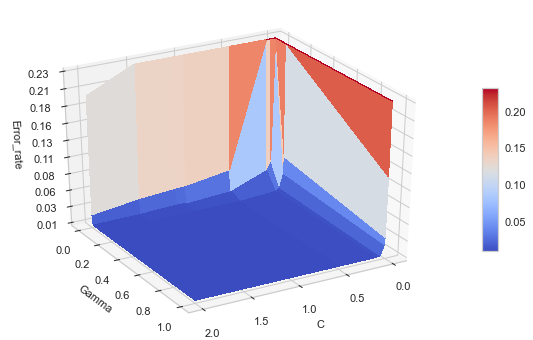

In [214]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

param_C =  [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 1.0001, 1.0005, 1.001, 1.005, 1.01, 
            1.05, 1.1, 1.5, 2.0]
param_gamma= [1.0,0.1, 0.01, 0.001, 0.0001]

mn = min(min(accuracy))
mx = max(max(accuracy))
X = np.array(param_C) 
Y = np.array(param_gamma) 
Z= np.array(accuracy) 
X, Y = np.meshgrid(X, Y)

fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(X, Y, Z.T, cmap=cm.coolwarm,
                       linewidth=100, antialiased=False)

#ax.set(xlabel='C', ylabel='Gamma', zlabel='Error_rate')
ax.set_xlabel('C', labelpad=10)
ax.set_ylabel('Gamma', labelpad=10)
ax.set_zlabel('Error_rate', labelpad=10)

# Customize the z axis.
ax.set_zlim(mn, mx)
ax.set_xticks([0.0, 0.5, 1, 1.5, 2])
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.view_init(30, 60)


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()



In [155]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
import matplotlib.pyplot as plt
import random


y = df['Occupancy']
X = df.drop(columns=['Occupancy'])

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000, stratify=y)

param_C =  [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
param_gamma= [1.0,0.1, 0.01, 0.001, 0.0001, 0.00001]

rate =[]
for i in param_C:
    tmp = []
    for j in param_gamma:
        print("C = " + str(i) + " Gamma = " + str(j))
        svm = SVC(C=i, gamma=j)
        svm.fit(X_train, y_train)
        y_true, y_pred = y_test, svm.predict(X_test)
        acc = accuracy_score(y_true, y_pred)
        error_rate = 1 - acc
        print("Error rate = " + str(error_rate))
        tmp.append(error_rate)   
    rate.append(tmp)

C = 0.0001 Gamma = 1.0
Error rate = 0.23103112840466922
C = 0.0001 Gamma = 0.1
Error rate = 0.23103112840466922
C = 0.0001 Gamma = 0.01
Error rate = 0.23103112840466922
C = 0.0001 Gamma = 0.001
Error rate = 0.23103112840466922
C = 0.0001 Gamma = 0.0001
Error rate = 0.23103112840466922
C = 0.0001 Gamma = 1e-05
Error rate = 0.23103112840466922
C = 0.001 Gamma = 1.0
Error rate = 0.1251621271076524
C = 0.001 Gamma = 0.1
Error rate = 0.23103112840466922
C = 0.001 Gamma = 0.01
Error rate = 0.23103112840466922
C = 0.001 Gamma = 0.001
Error rate = 0.23103112840466922
C = 0.001 Gamma = 0.0001
Error rate = 0.23103112840466922
C = 0.001 Gamma = 1e-05
Error rate = 0.23103112840466922
C = 0.01 Gamma = 1.0
Error rate = 0.026264591439688734
C = 0.01 Gamma = 0.1
Error rate = 0.03907263294422825
C = 0.01 Gamma = 0.01
Error rate = 0.23103112840466922
C = 0.01 Gamma = 0.001
Error rate = 0.23103112840466922
C = 0.01 Gamma = 0.0001
Error rate = 0.23103112840466922
C = 0.01 Gamma = 1e-05
Error rate = 0.2310

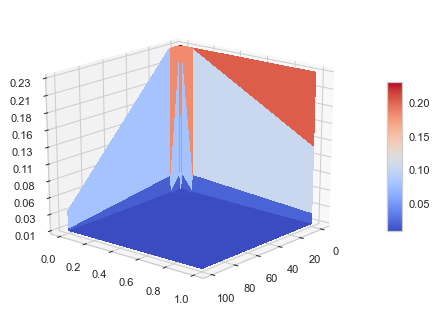

In [156]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
mn = min(min(accuracy))
mx = max(max(accuracy))
X = np.array(param_C) 
Y = np.array(param_gamma) 
Z= np.array(rate) 
X, Y = np.meshgrid(X, Y)

fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(X, Y, Z.T, cmap=cm.coolwarm,
                       linewidth=10, antialiased=False)

# Customize the z axis.
ax.set_zlim(mn, mx)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.view_init(20, 40)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()


In [216]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
# READ AND DROP COLUMNS
y = df['Occupancy']
X = df.drop(columns=['Occupancy'])

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000, stratify=y)

# Set the parameters by cross-validation
tuned_parameters = {
    'kernel' : ('linear', 'rbf', 'poly', 'sigmoid'),
    'C':(0.001, 0.01, 0.1, 1.0, 10.0, 100.0),
    'gamma': (1.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6),
}
# Set the parameters by cross-validation
k_fold = StratifiedKFold(n_splits=4, random_state=42)

#scores = ['recall', 'f1', 'accuracy' , 'precision']
scores = ['accuracy']

for score in scores:
    print("# Tuning hyper-parameters for ----> %s" % score)
    print()
    
    svm = SVC()
    
    clf = GridSearchCV(svm, tuned_parameters, error_score='raise', cv=k_fold, scoring=score)
                         
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    print("**** Matrice di Confusione *****")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(' True negative: %d False negative: %d' % (tn, fn))
    print(' True positive: %d False positive: %d' % (tp, fp))
    print("____________________________________________")

c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


# Tuning hyper-parameters for ----> accuracy

Best parameters set found on development set:

{'C': 1.0, 'gamma': 1.0, 'kernel': 'poly'}

Grid scores on development set:

0.931 (+/-0.020) for {'C': 0.001, 'gamma': 1.0, 'kernel': 'linear'}
0.892 (+/-0.007) for {'C': 0.001, 'gamma': 1.0, 'kernel': 'rbf'}
0.981 (+/-0.005) for {'C': 0.001, 'gamma': 1.0, 'kernel': 'poly'}
0.769 (+/-0.000) for {'C': 0.001, 'gamma': 1.0, 'kernel': 'sigmoid'}
0.931 (+/-0.020) for {'C': 0.001, 'gamma': 0.1, 'kernel': 'linear'}
0.769 (+/-0.000) for {'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}
0.769 (+/-0.000) for {'C': 0.001, 'gamma': 0.1, 'kernel': 'poly'}
0.769 (+/-0.000) for {'C': 0.001, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.931 (+/-0.020) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'linear'}
0.769 (+/-0.000) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}
0.769 (+/-0.000) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'poly'}
0.769 (+/-0.000) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.931 (+/-0.020) for {